In [1]:
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import itertools
import mdnet 
import os

#### Load Data ( .prmtop and .nc should be present)

In [2]:
data_dir = "/home/aaojha/Downloads/alad_vamp/data/no_bias"

In [3]:
traj_file = os.path.join(data_dir, "system_final.nc")
heavy_atoms_file = os.path.join(data_dir, "heavy_atoms_md.txt")
phi_psi_file = os.path.join(data_dir, "phi_psi_md.txt")
top = os.path.join(data_dir, "system_final.prmtop")

In [4]:
ref_pdb = "ref_system.pdb"

In [5]:
mdnet.create_heavy_atom_xyz(traj = traj_file, 
                            ref_pdb = ref_pdb, 
                            heavy_atoms_array = heavy_atoms_file, 
                            start = 0, stop = 50000, stride = 1)

<mdtraj.Topology with 1 chains, 3 residues, 22 atoms, 21 bonds>
[1, 4, 5, 6, 8, 10, 14, 15, 16, 18]
<mdtraj.Trajectory with 50000 frames, 22 atoms, 3 residues, and unitcells>
<mdtraj.Trajectory with 50000 frames, 10 atoms, 3 residues, and unitcells>
(50000, 10, 3)
(50000, 30)


In [6]:
mdnet.create_phi_psi(traj = traj_file, 
                     ref_pdb = ref_pdb, 
                     phi_psi_txt = phi_psi_file, 
                     start = 0, stop = 50000, stride = 1)

(50000, 1)
(50000, 1)
(50000, 2, 1)
(50000, 2)


In [7]:
traj_whole = np.loadtxt(heavy_atoms_file)
print(traj_whole.shape)
dihedral = np.loadtxt(phi_psi_file)
print(dihedral.shape)

(50000, 30)
(50000, 2)


#### Define Hyperparameters

In [8]:
tau = 1 # Tau, how much is the timeshift of the two datasets
batch_size = 1000 # Batch size for Stochastic Gradient descent
train_ratio = 0.9 # Which trajectory points percentage is used as training
network_depth = 6 # How many hidden layers the network has
layer_width = 100 # Width of every layer
learning_rate = 1e-4 # Learning rate used for the ADAM optimizer
output_size = 6 # How many output states the network has
nb_epoch = 60 # Iteration over the training set in the fitting process
epsilon = 1e-5

In [9]:
traj_data_points, input_size = traj_whole.shape

#### Initialized the VAMPnets wrapper class

In [10]:
vamp = mdnet.VampnetTools(epsilon = epsilon)

#### Shuffle trajectory and lagged trajectory together

In [11]:
length_data = traj_data_points - tau
traj_ord = traj_whole[:length_data]
traj_ord_lag = traj_whole[tau:length_data+tau]
dihedral_init = dihedral[:length_data]
indexes = np.arange(length_data)
np.random.shuffle(indexes)
traj = traj_ord[indexes]
traj_lag = traj_ord_lag[indexes]
dihedral_shuffle = dihedral_init[indexes]

#### Prepare data for tensorflow usage

In [12]:
length_train = int(np.floor(length_data * train_ratio))
length_vali = length_data - length_train
traj_data_train = traj[:length_train]
traj_data_train_lag = traj_lag[:length_train]
traj_data_valid = traj[length_train:]
traj_data_valid_lag = traj_lag[length_train:]
# Input of the first network
X1_train = traj_data_train.astype('float32')
X2_train  = traj_data_train_lag.astype('float32')
# Input for validation
X1_vali = traj_data_valid.astype('float32')
X2_vali = traj_data_valid_lag.astype('float32')
# Needs a Y-train set which we dont have.
Y_train = np.zeros((length_train,2*output_size)).astype('float32')
Y_vali = np.zeros((length_vali,2*output_size)).astype('float32')

#### Run several model iterations saving the best one, to help finding sparcely populated states

In [13]:
max_vm = 0
#attempts = 10
attempts = 2
losses = [vamp.loss_VAMP2_autograd]
for i in range(attempts):    
    # Clear the previous tensorflow session to prevent memory leaks
    #clear_session()
    tf.keras.backend.clear_session()
    # Build the model
    nodes = [layer_width]*network_depth
    Data_X = tf.keras.layers.Input(shape = (input_size,))
    Data_Y = tf.keras.layers.Input(shape = (input_size,))
    # Batch normalization layer improves convergence speed
    bn_layer = tf.keras.layers.BatchNormalization()
    # Instance layers and assign them to the two lobes of the network
    dense_layers = [tf.keras.layers.Dense(node, activation = 'elu') 
                    # if index_layer < 3 else 'linear nodes')
                    for index_layer,node in enumerate(nodes)]
    lx_branch = bn_layer(Data_X)
    rx_branch = bn_layer(Data_Y)
    for i, layer in enumerate(dense_layers):
        lx_branch = dense_layers[i](lx_branch)
        rx_branch = dense_layers[i](rx_branch)
    # Add a softmax output layer
    # Should be replaced with a linear activation layer if
    # the outputs of the network cannot be interpreted as states
    softmax = tf.keras.layers.Dense(output_size, activation='softmax')
    lx_branch = softmax(lx_branch)
    rx_branch = softmax(rx_branch)
    # Merge both networks to train both at the same time
    merged = tf.keras.layers.concatenate([lx_branch, rx_branch])
    # Initialize the model and the optimizer, and compile it with
    # the loss and metric functions from the VAMPnets package
    model = tf.keras.models.Model(inputs = [Data_X, Data_Y], outputs = merged)
    adam = tf.keras.optimizers.Adam(learning_rate = learning_rate/10)
    vm1 = np.zeros((len(losses), nb_epoch))
    tm1 = np.zeros_like(vm1)
    vm2 = np.zeros_like(vm1)
    tm2 = np.zeros_like(vm1)
    vm3 = np.zeros_like(vm1)
    tm3 = np.zeros_like(vm1)
    for l_index, loss_function in enumerate(losses):
        model.compile(optimizer = adam,
                      loss = loss_function,
                      metrics = [vamp.metric_VAMP, vamp.metric_VAMP2])
        # Train the model  
        hist = model.fit([X1_train, X2_train], Y_train ,
                         batch_size=batch_size,
                         epochs=nb_epoch,
                         validation_data=([X1_vali, X2_vali], Y_vali ),
                         verbose=0)
        vm1[l_index] = np.array(hist.history['val_metric_VAMP'])
        tm1[l_index] = np.array(hist.history['metric_VAMP'])
        vm2[l_index] = np.array(hist.history['val_metric_VAMP2'])
        tm2[l_index] = np.array(hist.history['metric_VAMP2'])
        vm3[l_index] = np.array(hist.history['val_loss'])
        tm3[l_index] = np.array(hist.history['loss'])
    vm1 = np.reshape(vm1, (-1))
    tm1 = np.reshape(tm1, (-1))
    vm2 = np.reshape(vm2, (-1))
    tm2 = np.reshape(tm2, (-1))
    vm3 = np.reshape(vm3, (-1))
    tm3 = np.reshape(tm3, (-1))
    # Average the score obtained in the last part of the training process
    # in order to establish which model is better and thus worth saving
    score = vm1[-5:].mean()
    extra_msg = ''
    if score > max_vm:
        extra_msg = ' - Highest'
        best_weights = model.get_weights()
        max_vm = score
        vm1_max = vm1
        tm1_max = tm1
        vm2_max = vm2
        tm2_max = tm2
        vm3_max = vm3
        tm3_max = tm3  
    print('Score: {0:.2f}'.format(score) + extra_msg)

Score: 5.00 - Highest
Score: 5.00 - Highest


#### Recover the saved model and its training history

In [14]:
model.set_weights(best_weights)
tm1 = np.array(tm1_max)
tm2 = np.array(tm2_max)
tm3 = np.array(tm3_max)
vm1 = np.array(vm1_max)
vm2 = np.array(vm2_max)
vm3 = np.array(vm3_max)

#### Training result visualization

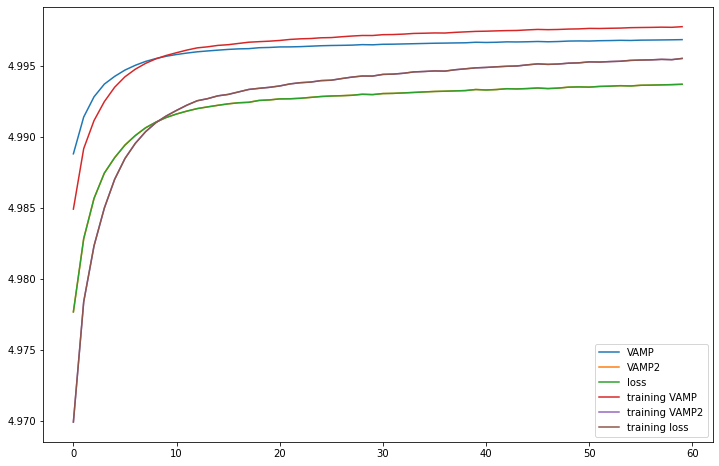

In [15]:
plt.figure(figsize=(12,8))
plt.plot(vm1, label = 'VAMP')
plt.plot(vm2, label = 'VAMP2')
plt.plot(-vm3, label = 'loss')
plt.plot(tm1, label = 'training VAMP')
plt.plot(tm2, label = 'training VAMP2')
plt.plot(-tm3, label = 'training loss')
plt.legend()
plt.show()

In [16]:
# Transform the input trajectory using the network
states_prob = model.predict([traj_ord, traj_ord_lag])[:, :output_size]
# Order the output states based on their population
coor_pred = np.argmax(states_prob, axis = 1)
indexes = [np.where(coor_pred == np.multiply(np.ones_like(coor_pred), n)) 
           for n in range(output_size)]
states_num = [len(i[0]) for i in indexes]
states_order = np.argsort(states_num).astype('int')[::-1]
pred_ord = states_prob[:,states_order]

In [17]:
index_for_we = []
for i in indexes:
    index_frames = list(list(i)[0])
    sel_frames = index_frames[:10]
    index_for_we.append(sel_frames)
index_for_we = list(itertools.chain.from_iterable(index_for_we))
print(index_for_we)
print(len(index_for_we))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 13306, 13307, 13327, 13328, 13332, 13334, 13335, 13337, 13343, 13344, 42939, 42940, 42941, 42942, 42943, 42944, 42945, 42946, 42947, 42948, 6993, 7002, 7003, 7004, 7005, 7006, 7302, 7303, 7304, 7305, 12414, 12415, 12416, 12417, 12418, 12419, 12420, 12428, 12429, 12432, 43221, 43226, 43227, 43232, 43233, 43234, 43235, 43236, 43237, 43238]
60


#### Visualize the population of the states

States population: [46.86693734 20.37040741 11.450229   10.43220864  7.78615572  3.09406188]%


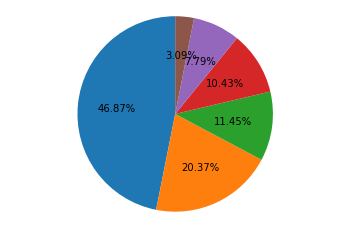

In [18]:
def print_states_pie_chart():
    coors = []
    maxi = np.max(pred_ord, axis= 1)
    for i in range(output_size):
        coors.append(len(np.where(pred_ord[:,i] == maxi)[0]))
    fig1, ax1 = plt.subplots()
    ax1.pie(np.array(coors), autopct='%1.2f%%', startangle=90)
    ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    print('States population: '+ str(np.array(coors)/len(maxi)*100)+'%')
    plt.show()
print_states_pie_chart()

#### Visualize how the 4 states are placed on the Ramachandran plot

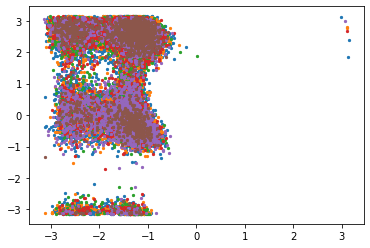

In [19]:
maxi_train = np.max(pred_ord, axis= 1)
coor_train = np.zeros_like(pred_ord)
for i in range(output_size):
    coor_train = np.where(pred_ord[:,i]== maxi_train)[0]
    plt.scatter(dihedral_init[coor_train,0], dihedral_init[coor_train,1], s=5)
plt.axes = [[-np.pi, np.pi],[-np.pi, np.pi]]

#### For each state, visualize the probabilities the different trajectory points have to belong to it

/home/aaojha/anaconda3/envs/mdnet/lib/python3.7/site-packages/ipykernel_launcher.py:38: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


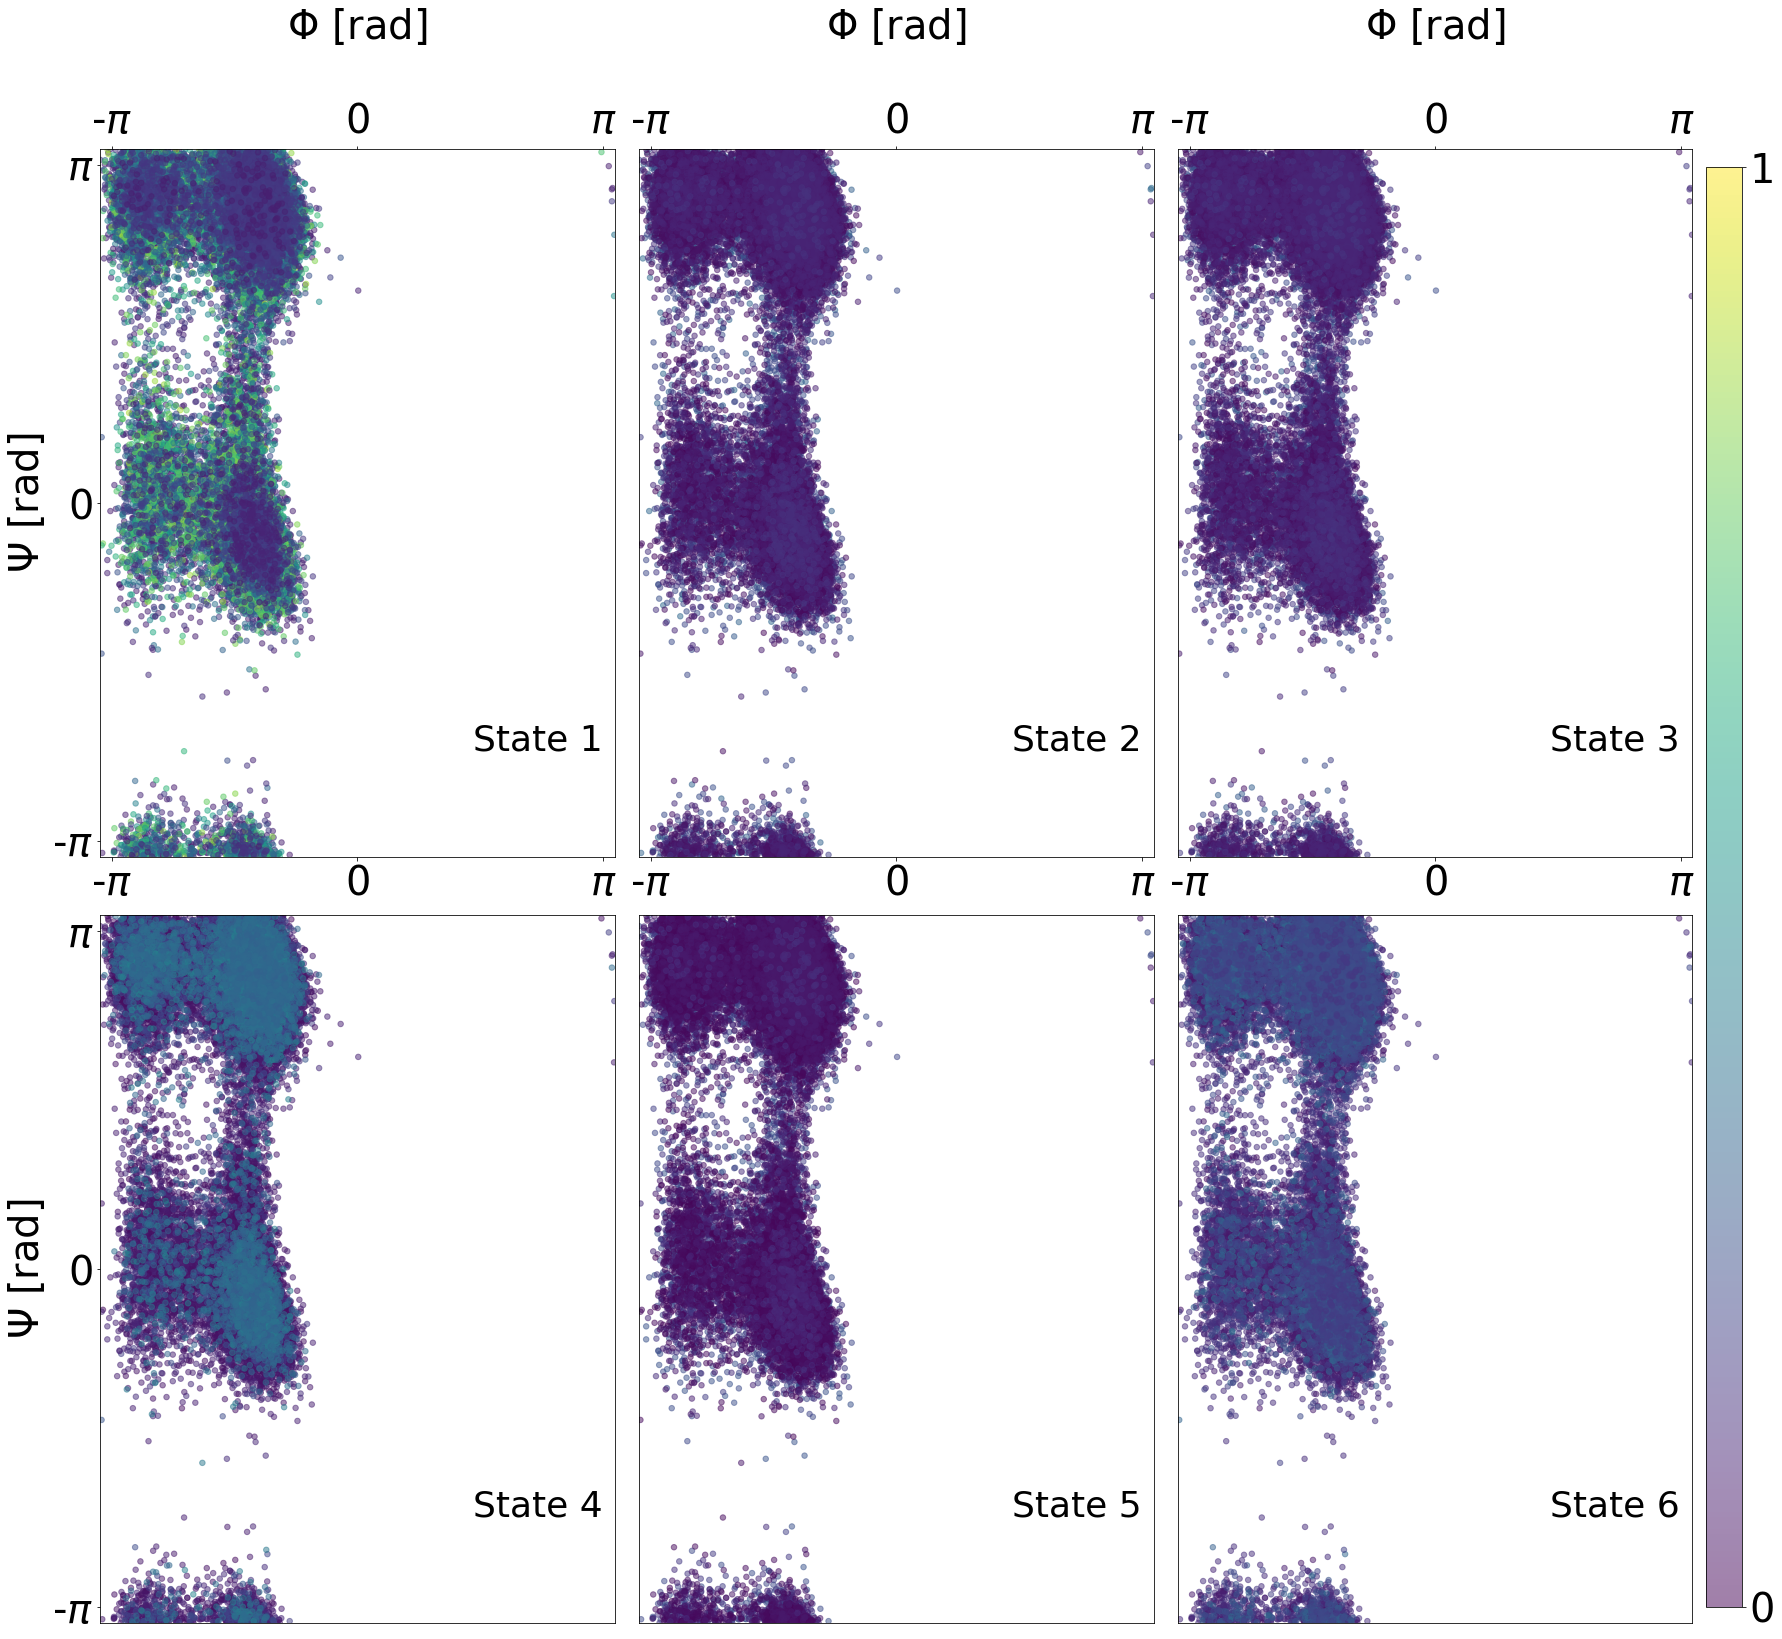

In [20]:
fig = plt.figure(figsize=(25,25))
gs1 = gridspec.GridSpec(2, int(np.ceil(output_size/2)))
gs1.update(wspace=0.05, hspace = 0.05)
for n in range(output_size):
    ax = plt.subplot(gs1[n])
    im = ax.scatter(dihedral_init[:,0], dihedral_init[:,1], s=30,
                    c = pred_ord[:,n],
                    alpha=0.5,
                    vmin = 0, vmax = 1
                    )
    plt.axis('on')
    title = 'State '+str(n + 1)
    ax.text(.85, .15, title,
        horizontalalignment='center',
        transform=ax.transAxes,  fontdict = {'size':36})
    if (n < 3):
        ax.set_xticks([-3, 0, 3])
        ax.set_xticklabels([r'-$\pi$', r'$0$', r'$\pi$'])
        ax.xaxis.set_tick_params(top='on', bottom='off', labeltop='on', labelbottom='off')
        ax.xaxis.set_tick_params(labelsize=40)
    else:
        ax.set_xticks([])
    if (n%3==0):
        ax.set_yticks([-3, 0, 3])
        ax.set_yticklabels([r'-$\pi$', r'$0$', r'$\pi$'])
        ax.yaxis.set_tick_params(labelsize=40)
    else:
        ax.set_yticks([])
#    ax.set_aspect('equal')
    ax.set_xlim([-np.pi, np.pi]);
    ax.set_ylim([-np.pi, np.pi]);
    if (n%3 == 0):
        ax.set_ylabel(r'$\Psi$ [rad]', fontdict = {'size':40})
    if (n < 3):
        ax.set_xlabel(r'$\Phi$ [rad]', fontdict = {'size':40}, position = 'top')
        ax.xaxis.set_label_coords(0.5,1.2)
gs1.tight_layout(fig, rect=[0, 0.03, 0.95, 0.94])
fig.show()
cax = fig.add_axes([0.95, 0.05, 0.02, 0.8])
cbar = fig.colorbar(im, cax=cax, ticks=[0, 1])
cbar.ax.yaxis.set_tick_params(labelsize=40)

#### Markov Model Estimation

#### Estimate the implied timescales

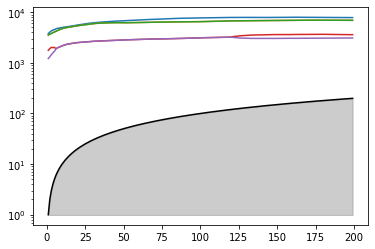

In [21]:
max_tau = 200
lag = np.arange(1, max_tau, 1)
its = vamp.get_its(pred_ord, lag)
vamp.plot_its(its, lag)

#### Chapman-Kolmogorov test for the estimated koopman operator

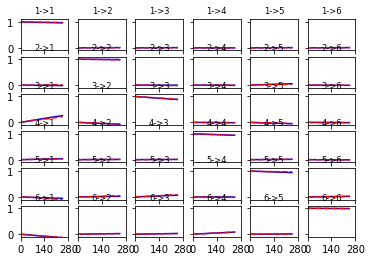

In [22]:
steps = 8
tau_msm = 35
predicted, estimated = vamp.get_ck_test(pred_ord, steps, tau_msm)
vamp.plot_ck_test(predicted, estimated, output_size, steps, tau_msm)